# LSTM MODEL #

In [ ]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


: 

# Importing the  Necessary Libraries for our Model 

This Mark Down includes the libraries required for extracting data, preprocessing, sentiment analysis generation, deep learning, and evaluation metrics.

- **`yfinance`**: This library acts as an an API-like Python library to fetch historical stock market data of Sage and FTSE- 100.
- **`pandas` and `numpy`**: We Import this Library For data manipulation and numerical computations.
- **`vaderSentiment`**: This libary acts as a sentiment analysis synthesiser.
- **`sklearn.preprocessing.MinMaxScaler`**: This library scales features to a normalized range.
- **`tensorflow.keras`**: In order To build and train the LSTM model with layers like LSTM, Dense, Dropout, and Bidirectional we use keras 
- **`tensorflow.keras.optimizers.Adam`**: Widely known Optimiser in the deep learning model.
- **`sklearn.metrics`**: We use this For evaluating the model's performance using various metrics such as RMSE, MAE, R-squared, precision, recall, F1-score, and accuracy.
- **`matplotlib` and `seaborn`**: We use this for visualizing data distributions and model predictions.


In [ ]:

# Step 1: Fetch Sage PLC and FTSE 100 Data
stock_symbol = 'AAPL'
stock_data = yf.Ticker(stock_symbol)
sage_stock = stock_data.history(period='1d', start='2013-01-01', end='2024-11-01')

ftse_data = yf.download("^FTSE", start="2013-01-01", end="2024-11-01")


[*********************100%***********************]  1 of 1 completed


### Step 1: In this Step we Fetch Sage PLC and FTSE 100 Data

This step involves fetching historical financial data for **Sage PLC (SGE.L)** and the **FTSE 100 Index** using the `yfinance` library. The data includes daily stock prices from January 1, 2013, to November 1, 2024.


In [ ]:

# Convert both DateTime indexes to timezone-naive
sage_stock.index = sage_stock.index.tz_localize(None)
ftse_data.index = ftse_data.index.tz_localize(None)


### Convert DateTime Indexes to Timezone-Naive

In this step, the **DateTime indexes** for both the Sage PLC data (`sage_stock`) and FTSE 100 data (`ftse_data`) have been converted to timezone-naive format. This ensures that the DateTime objects do not have timezone information, allowing for seamless merging and comparison of the datasets.



In [ ]:

# Merge FTSE Close data into sage_stock
sage_stock = sage_stock.merge(ftse_data[['Close']], how='outer', left_index=True, right_index=True, suffixes=('', '_FTSE'))
sage_stock.rename(columns={'Close_FTSE': 'FTSE_Close'}, inplace=True)


### Step 2: Merge FTSE Close Data into Sage PLC Data

In this step, we would be integrating the FTSE 100 index data with Sage PLC's stock data to include external market influences as an feature in our analysis.


In [ ]:

# Fill missing values
sage_stock['FTSE_Close'] = sage_stock['FTSE_Close'].interpolate(method='linear').fillna(method='bfill')
sage_stock['Close'] = sage_stock['Close'].fillna(method='bfill')


/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_72334/2720209717.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ticker_df['FTSE_Close'] = ticker_df['FTSE_Close'].interpolate(method='linear').fillna(method='bfill')
/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_72334/2720209717.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ticker_df['Close'] = ticker_df['Close'].fillna(method='bfill')


### Step 3: Handle Missing Values in the Dataset

This step will be ensuring that the data used for analysis and modelling is complete and free of gaps, as this is crucial for time-series forecasting models like Prophet and LSTM.

In [ ]:

# Step 2: Simulate Sentiment Data with VADER
analyzer = SentimentIntensityAnalyzer()
text_data = [
    "Sage performs well in the Market", 
    "Uncertainty around the global economy is rising and affecting Sage", 
    "Sage reported a strong quarterly earnings"
]
text_data = (text_data * ((len(sage_stock) // len(text_data)) + 1))[:len(sage_stock)]
sage_stock['Sentiment'] = [analyzer.polarity_scores(text)['compound'] for text in text_data]


### Step 4: Simulate Sentiment Data Using VADER

This step will be on including sentiment data into the already existing dataset in order to enhance the forecasting model from the behavior of the stock prices based on sentiment.

In [ ]:

# Step 3: Feature Engineering - Adding Moving Averages and Volatility
sage_stock['MA_10'] = sage_stock['Close'].rolling(window=10).mean()
sage_stock['MA_30'] = sage_stock['Close'].rolling(window=30).mean()
sage_stock['MA_50'] = sage_stock['Close'].rolling(window=50).mean()
sage_stock['Volatility'] = sage_stock['Close'].rolling(window=10).std()
sage_stock.fillna(method='bfill', inplace=True)

/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_72334/2711375660.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ticker_df.fillna(method='bfill', inplace=True)


### Step 5: Feature Engineering - Adding Moving Averages and Volatility

For this purpose more features are created to incorporate the dynamics and fluctuations in stock market prices. These features give the model more detailed data to work with to identify trends in the stockprices’ fluctuations.

In [ ]:
# Step 4: Data Scaling
data_scaler = MinMaxScaler()
scaled_sage_data = data_scaler.fit_transform(sage_stock[['Close', 'Sentiment', 'MA_10', 'MA_30', 'MA_50', 'Volatility', 'FTSE_Close']])

The MinMaxScaler scales each feature to a range of [0, 1]. This prevents features with larger magnitudes (e.g., Close or FTSE_Close) from dominating features with smaller magnitudes (e.g., Sentiment or Volatility).
The output, scaled_sage_data, is a NumPy array where all features are normalized, ensuring consistent input for the model. In this step we are Scaling the range of all features, improving the convergence speed and stability of the LSTM model during training. It ensures that no single feature disproportionately affects the model's learning process.

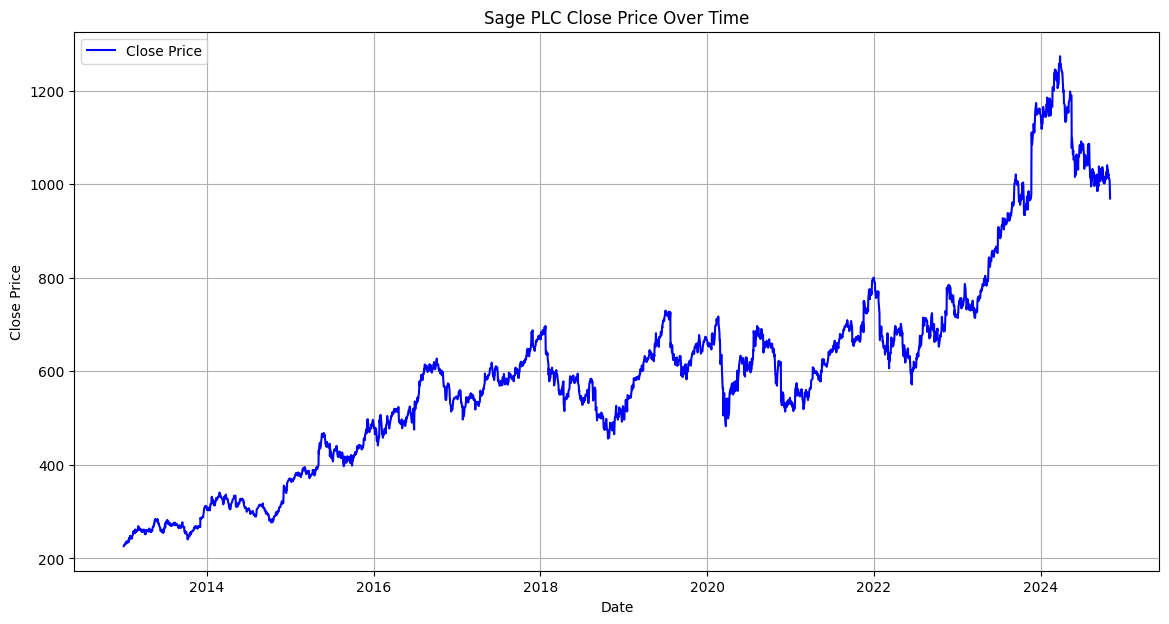

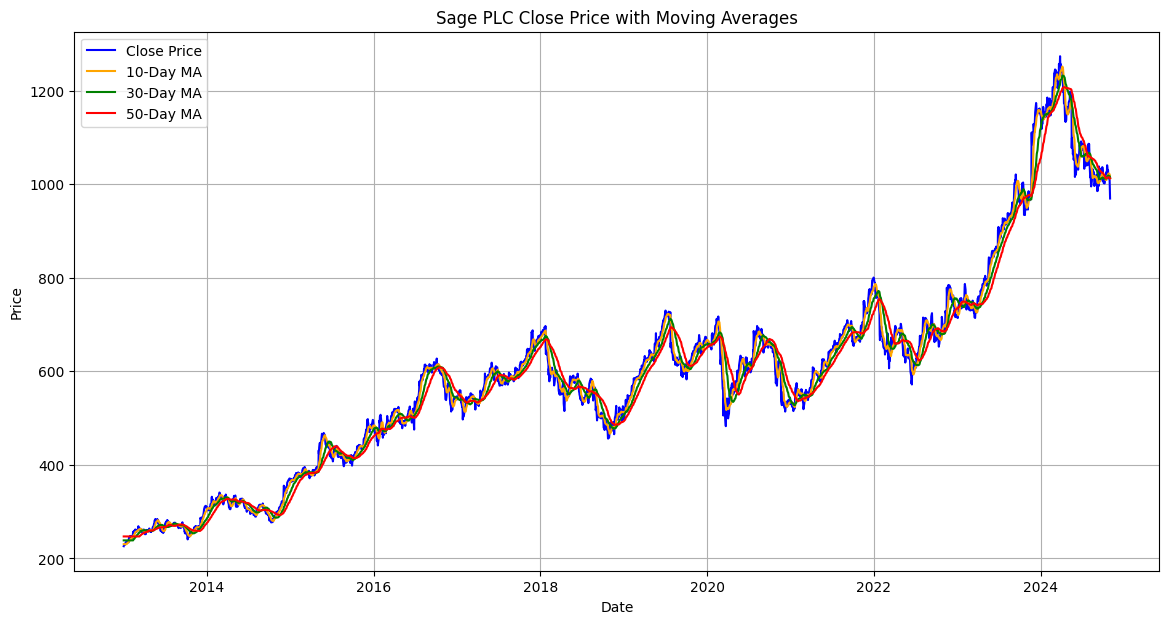

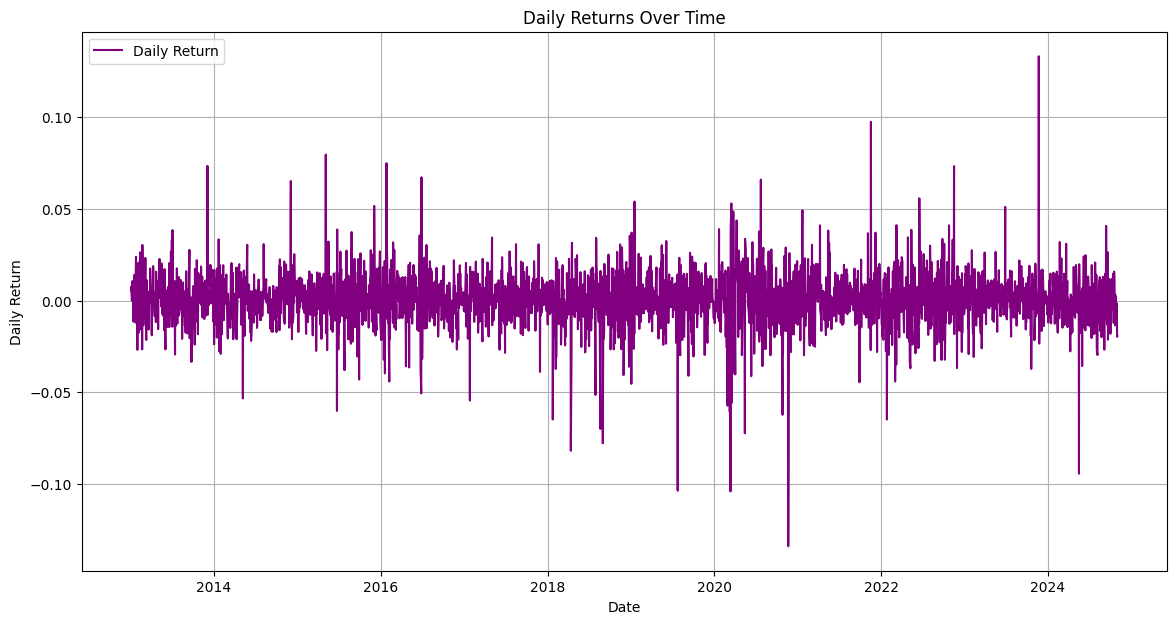

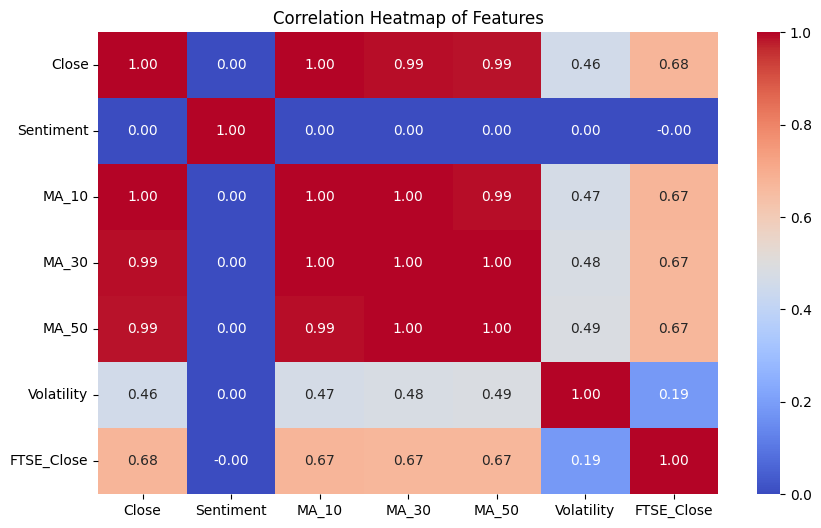

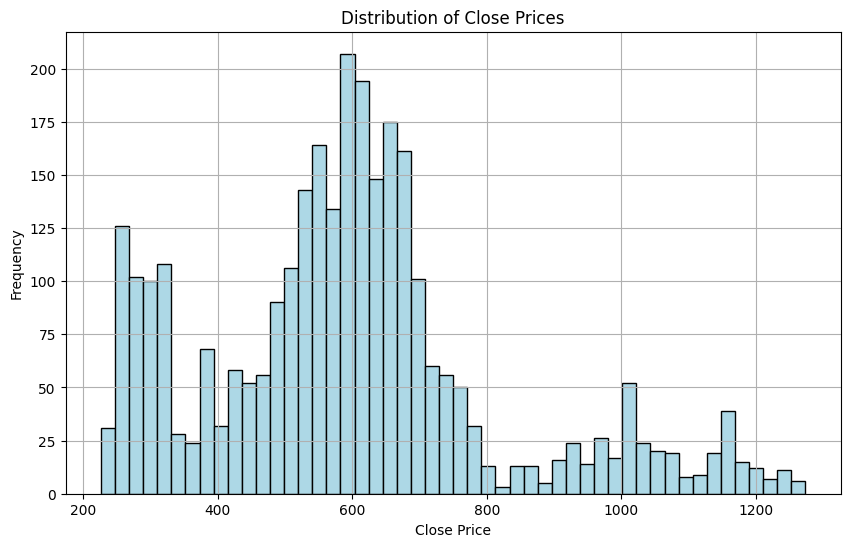

<Figure size 1000x600 with 0 Axes>

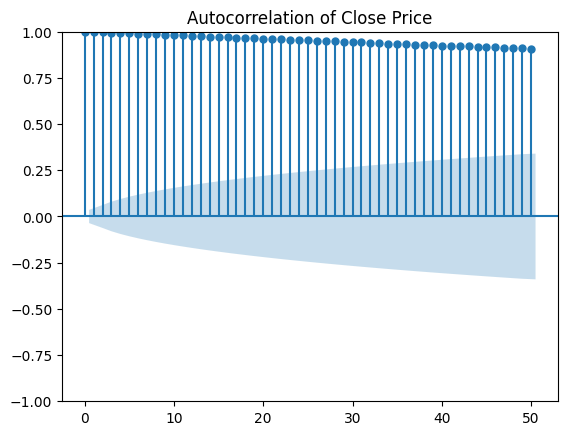

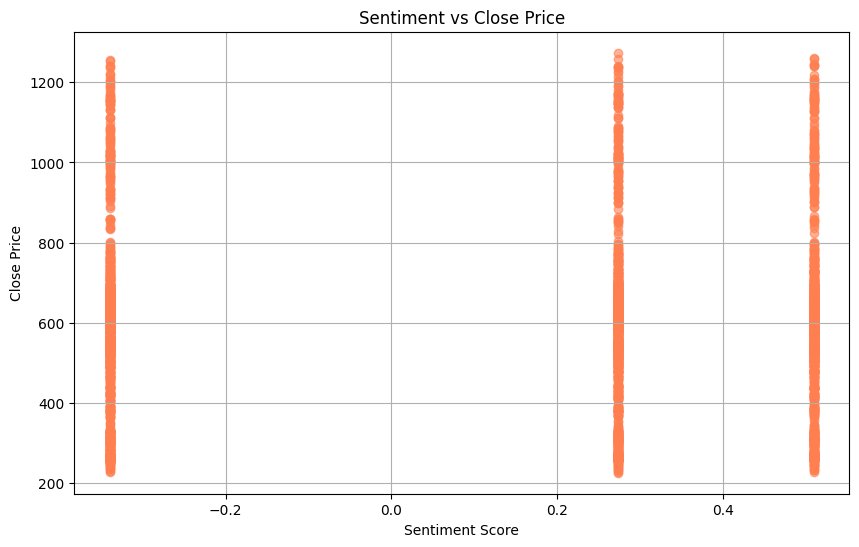

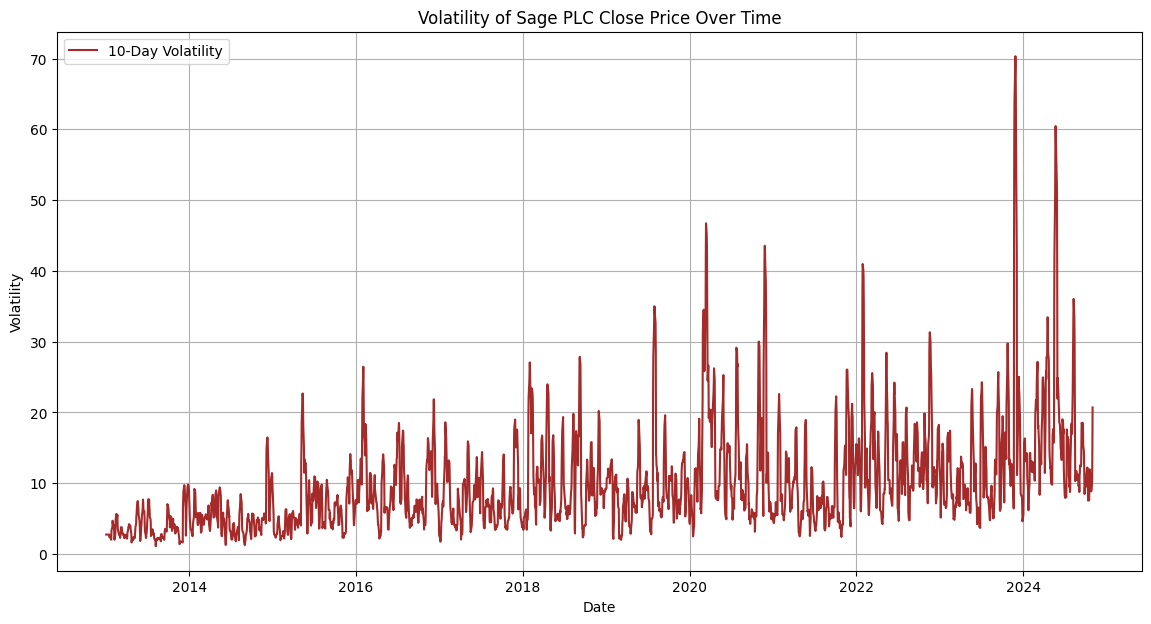

In [ ]:
# Step 1: Plotting Close Price Over Time
plt.figure(figsize=(14, 7))
plt.plot(sage_stock['Close'], color='blue', label='Close Price')
plt.title('Sage PLC Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Step 2: Moving Averages
# Plot Close Price along with Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(sage_stock['Close'], color='blue', label='Close Price')
plt.plot(sage_stock['MA_10'], color='orange', label='10-Day MA')
plt.plot(sage_stock['MA_30'], color='green', label='30-Day MA')
plt.plot(sage_stock['MA_50'], color='red', label='50-Day MA')
plt.title('Sage PLC Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Step 3: Daily Returns to Understand Volatility
sage_stock['Daily Return'] = sage_stock['Close'].pct_change()
plt.figure(figsize=(14, 7))
plt.plot(sage_stock['Daily Return'], color='purple', label='Daily Return')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(sage_stock[['Close', 'Sentiment', 'MA_10', 'MA_30', 'MA_50', 'Volatility', 'FTSE_Close']].corr(), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()

# Step 5: Distribution of Close Prices
plt.figure(figsize=(10, 6))
plt.hist(sage_stock['Close'], bins=50, color='lightblue', edgecolor='black')
plt.title('Distribution of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Step 6: Autocorrelation Plot of Close Price
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(sage_stock['Close'].dropna(), lags=50)
plt.title('Autocorrelation of Close Price')
plt.show()

# Step 7: Scatter Plot of Sentiment vs Close Price to check any potential relationship
plt.figure(figsize=(10, 6))
plt.scatter(sage_stock['Sentiment'], sage_stock['Close'], alpha=0.6, color='coral')
plt.title('Sentiment vs Close Price')
plt.xlabel('Sentiment Score')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

# Step 8: Volatility over Time
plt.figure(figsize=(14, 7))
plt.plot(sage_stock['Volatility'], color='brown', label='10-Day Volatility')
plt.title('Volatility of Sage PLC Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


#### Exploratory Data Analysis

This section is a detailed description of Sage PLC stock price data analysis using various formats of presenting data and analytical tools. It is important in order to identify trends or relationships or patterns within the data which we can use in the modelling process.

#### Step 1:  Plotting Close Price Over Time
Purpose: For the development of the concept, to facilitate better analysis and make the audience and the author more comfortable reading, it is necessary to draw a graph representing the trend of the closing price at Sage PLC in the period under consideration.

### Step 2: Moving Averages
In order to study short term, medium term and long term trends of the price using moving averages.

### Step 3: To measure the Volatility, we have calculated Daily Returns.
Purpose: Namely, to track regular fluctuations of the stock daily closing price.

### Step 4: Correlation Heatmap
In order to determine the interconnection between some of the features – to determine feature interdependence.

### Step 5: Distribution of Close Prices
Purpose: In order to calculate the frequency distribution of closing prices that might facilitate identification of the price ranges and patterns.

### Step 6: Basically, the Autocorrelation plot of the Close Price will be constructed.
Purpose: To test EGG for the current and previous day prices to determine the level of association between the stock price and its previous prices with an aim of finding out the time series pattern.

### Step 7: Scatter Plot of Sentiment vs Price that closes
Purpose: Lastly, to present the distribution of sentiment scores and closing prices in order to establish whether sentiment influences the price of a stock.

### Step 8: Volatility Over Time
Purpose: This will help to make a realization of the fluctuation within the price of the stock in respect of the time factor in a bid to determine the high and low period of stock market activity.

In [ ]:

# Step 4: Data Scaling
data_scaler = MinMaxScaler()
scaled_sage_data = data_scaler.fit_transform(sage_stock[['Close', 'Sentiment', 'MA_10', 'MA_30', 'MA_50', 'Volatility', 'FTSE_Close']])


### Step 4: Data Scaling

In this step, we have scaled the date using the `MinMaxScaler` to ensure all features are within a specified range (default 0 to 1). 
Data Scaling helps us to improve model performance by standardizing the feature values.

In [ ]:

# Step 5: Prepare Data for LSTM
def create_dataset(data, look_back=90):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i, 0])  # Close price as target
    return np.array(X), np.array(y)

look_back = 90
X, y = create_dataset(scaled_sage_data, look_back)


### Step 5: Preparation of Data for LSTM

In this step we prepares the scaled data for training the LSTM model. A helper function, `create_dataset`, is used to generate input-output pairs based on a sliding window approach.

In [13]:

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


### Split Data into Training and Test Sets

This step divides the prepared dataset into training and test sets, ensuring the model is trained on one portion of the data and tested on a separate portion to evaluate its performance.


Training set (X_train, y_train) is used to train the LSTM model.
Test set (X_test, y_test) is used to evaluate the model's performance on unseen data.

train_size = int(len(X) * 0.8): 80% of the data is used for training. The remaining 20% is reserved for testing.

X[:train_size]: The first 80% of the input data is assigned to X_train.
X[train_size:]: The last 20% of the input data is assigned to X_test.

y[:train_size]: The first 80% of the target values is assigned to y_train.
y[train_size:]: The last 20% of the target values is assigned to y_test.

Splitting the data ensures that the model is evaluated on data it has not seen during training, providing an unbiased measure of performance.
By maintaining the temporal order, it prevents information leakage from the future into the past, which is critical for time-series forecasting.

In [ ]:

# Step 6: Build the LSTM Model
LSTM_model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.00005)
LSTM_model.compile(optimizer=optimizer, loss='mean_squared_error')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Step 6: Build the LSTM Model

This step involves building an LSTM-based neural network using Keras to model time-series data. The model includes bidirectional LSTM layers to capture both forward and backward dependencies in the data.

* Model Architecture 

Sequential API: Allows stacking layers in a linear fashion.
(X_train.shape[1], X_train.shape[2]): This step defines the input dimensions

Layers:

Bidirectional(LSTM(256, return_sequences=True)): The Bidirectional LSTM processes the data in both forward and backward directions to capture temporal dependencies by adding 256 Number of units or neurons in the layer.
Dropout(0.2): This step determines that we randomly drops 20% of the neurons to prevent overfitting.
Bidirectional(LSTM(128, return_sequences=False)): And then we add Another bidirectional LSTM layer with 128 units.
We use Adam Optimizer which is an Adaptive optimizer with a small learning rate of 0.00005 for stable convergence.
We calculate the Loss Function mean_squared_error which measures the difference between predicted and actual values, suitable for regression tasks.
This model processes sequential data, applies LSTM layers to learn temporal dependencies, and predicts the target variable effectively.
The compilation step optimizes the model for training using a small learning rate and minimizes the mean squared error.

In [ ]:

# Step 7: Train the model
history = LSTM_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - loss: 0.0212 - val_loss: 0.0059
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - loss: 0.0022 - val_loss: 0.0045
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 288ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - loss: 8.6096e-04 - val_loss: 0.0026
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 288ms/step - loss: 8.8308e-04 - val_loss: 0.0042
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 288ms/step - loss: 8.1598e-04 - val_loss: 0.0038
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - loss: 7.6868e-04 - val_loss: 0.0036
Epoch 12/50
73/73 ━━━━━━━

### Step 7: Train the Model

In this step, the LSTM model is trained using the prepared data. The training process involves feeding the training data to the model and validating its performance on the test data.


In [ ]:

# Step 8: Prediction and Evaluation
predicted_prices = LSTM_model.predict(X_test)
predicted_prices = data_scaler.inverse_transform(np.concatenate((predicted_prices, np.zeros((len(predicted_prices), scaled_sage_data.shape[1] - 1))), axis=1))[:, 0]
actual_prices = data_scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), scaled_sage_data.shape[1] - 1))), axis=1))[:, 0]


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step


### Step 8: Prediction and Evaluation

After we train the model, predictions are made on the test dataset. 
The predicted and actual prices are then transformed back to their original scale to evaluate the model's performance.



In [17]:

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100
msle = np.mean((np.log1p(actual_prices) - np.log1p(predicted_prices)) ** 2)
r2 = r2_score(actual_prices, predicted_prices)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MSLE: {msle:.4f}")
print(f"R-squared: {r2:.4f}")


RMSE: 33.6362
MAE: 24.7478
MAPE: 2.50%
MSLE: 0.0011
R-squared: 0.9636


### Evaluation Metrics

After generating predictions, it is essential to evaluate the model's performance using various error metrics. These metrics provide insights into how well the model predicts the actual prices.


In [18]:

# Symmetric Mean Absolute Percentage Error (sMAPE)
smape = np.mean(2 * np.abs(actual_prices - predicted_prices) / (np.abs(actual_prices) + np.abs(predicted_prices))) * 100
print(f"sMAPE: {smape:.2f}%")


sMAPE: 2.54%


### Symmetric Mean Absolute Percentage Error (sMAPE)

The Symmetric Mean Absolute Percentage Error (sMAPE) is an evaluation metric used to measure the accuracy of a predictive model. It provides a percentage-based error that accounts for both over-predictions and under-predictions symmetrically.


In [19]:

# Directional Accuracy
actual_direction = (np.diff(actual_prices) > 0).astype(int)
predicted_direction = (np.diff(predicted_prices) > 0).astype(int)


### Directional Accuracy

Directional Accuracy is the metric that we used to evaluate whether the predicted trend direction matches the actual trend direction in time-series forecasting.


In [20]:

# Align lengths by removing the first value
actual_direction = actual_direction[1:]
predicted_direction = predicted_direction[1:]


### Align Lengths by Removing the First Value

When calculating directional accuracy, the lengths of `actual_direction` and `predicted_direction` needs to be matched. This adjustment ensures proper alignment for comparison.

In [21]:

# Classification metrics
precision = precision_score(actual_direction, predicted_direction)
recall = recall_score(actual_direction, predicted_direction)
accuracy = accuracy_score(actual_direction, predicted_direction)
f1 = f1_score(actual_direction, predicted_direction)

print("\nDirectional Accuracy Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Directional Accuracy Metrics:
Accuracy: 0.5043
Precision: 0.5119
Recall: 0.6554
F1 Score: 0.5748


### Classification Metrics for Directional Accuracy

These metrics are used for evaluating the model's ability to predict the direction of price changes (up or down) using classification metrics. They provide a deeper understanding of how well the predicted directions align with actual directions.


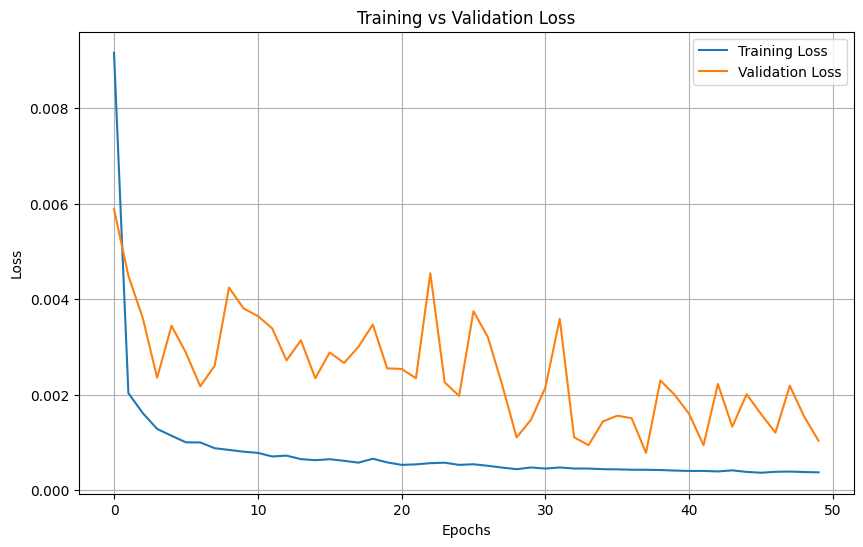

In [22]:

# Additional Plots
# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Additional Plots: Training vs Validation Loss

We use this cell for Plotting the training and validation loss over epochs. This helps us visualize how well the model is learning and whether it is overfitting or underfitting.


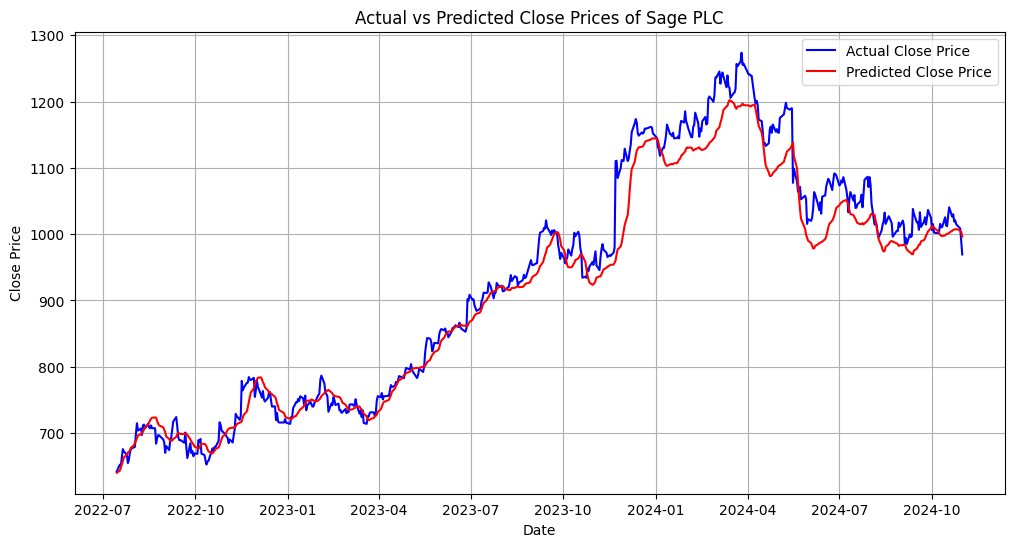

In [ ]:

# Line Plot of Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(sage_stock.index[look_back + train_size:]), actual_prices, label="Actual Close Price", color='blue')
plt.plot(pd.to_datetime(sage_stock.index[look_back + train_size:]), predicted_prices, label="Predicted Close Price", color='red')
plt.title('Actual vs Predicted Close Prices of Sage PLC')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


### Line Plot: Actual vs Predicted Close Prices

This code block will be plotting an comparision line chart of the actual and predicted close prices over time, providing a visual representation of how well the model's predictions align with the true values.


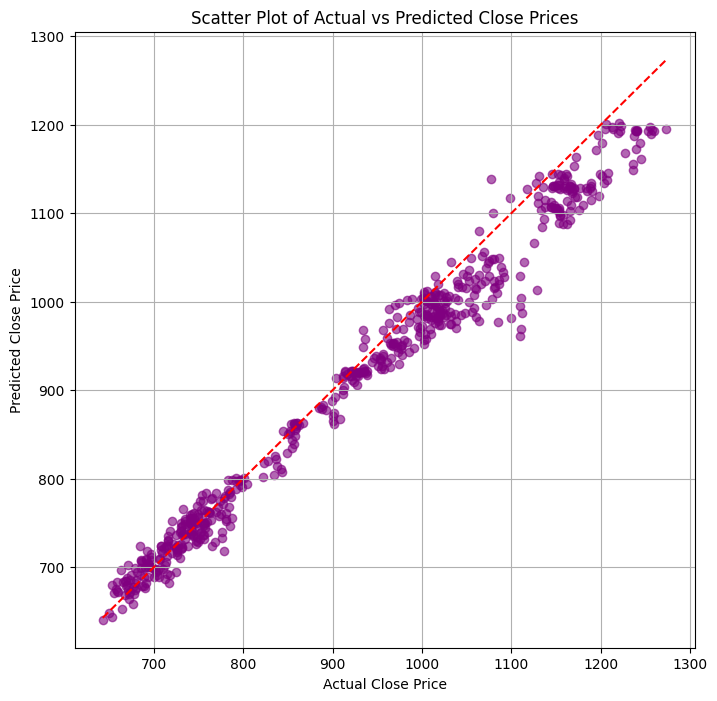

In [24]:

# Scatter Plot of Actual vs Predicted Prices
plt.figure(figsize=(8, 8))
plt.scatter(actual_prices, predicted_prices, alpha=0.6, color='purple')
plt.plot([min(actual_prices), max(actual_prices)], [min(actual_prices), max(actual_prices)], 'r--')  # Diagonal reference line
plt.title("Scatter Plot of Actual vs Predicted Close Prices")
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.grid(True)
plt.show()


### Scatter Plot: Actual vs Predicted Close Prices

This code block plots a scatter plot that is  used to visualize the relationship between the actual and predicted close prices. The plot includes a diagonal reference line to indicate perfect predictions.

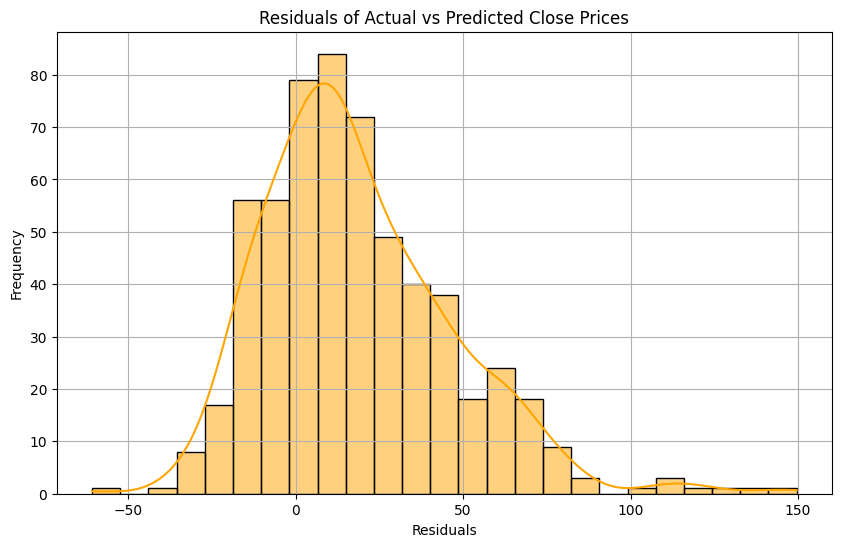

In [25]:

# Residual Plot for Actual vs Predicted Prices
residuals = actual_prices - predicted_prices
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='orange')
plt.title("Residuals of Actual vs Predicted Close Prices")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Residual Plot: Actual vs Predicted Close Prices

This code block is used for plotting a residual plot which visualizes the differences (residuals) between actual and predicted close prices. It helps identify patterns in the errors and assess the model's accuracy.
